# Assessing the zero-shot technique on a cross-lingual transfer learning task

## <i>by Tim Ottens and Thomas van Osch </i>

---


This notebook is divided in several sections:
- Pre-processing
- Training
- Evaluation:
    - Masking task
    - POS-tagging task
- Displaying the results

---

## Pre-Processing

First we parse the provided text data files with [spaCy](https://spacy.io/models/nl)

In [ ]:
import pickle
import tagger

#create parsed_corpus files from simple text that also include POS tags (Python 2.7 required)
tagger.parse_corpus(folder_map='data/')

corpus_train = pickle.load(open("data/parsed_train.pt", "rb"))
corpus_dev = pickle.load(open("data/parsed_valid.pt", "rb"))
corpus_test = pickle.load(open("data/parsed_test.pt", "rb"))

Then we create embeddings for both english and dutch BERT. Both models are taken from the [Huggingface](https://huggingface.co/transformers/pretrained_models.html) library. 

In [ ]:
#Create embeddings for each model

import os
import torch
import senreps
import numpy as np
from transformers import *
from polyglot.mapping import Embedding
from polyglot.downloader import downloader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = {}
nl_en = {}
en_nl = {}

#File created when running generate_dict.py
with open('data/filtered_en_nl_dict.txt', 'r') as bidict:
    for trans in bidict:
        nl, en = trans.split()
        nl_en[nl] = en
        en_nl[en] = nl

#Embeddings retrieved from polyglot
embeddings = Embedding.load("embeddings2/nl/embeddings_pkl.tar.bz2")

#Get sentence representations for the english BERT
model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=True).to(device=device)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model_type = 'TF'

data['train'] = senreps.proc_embeddings(corpus_train, model, tokenizer, embeddings, nl_en, 
                                        model_type, device, concat=False)

data['dev'] = senreps.proc_embeddings(corpus_dev, model, tokenizer, embeddings, nl_en, 
                                        model_type, device, concat=False)

data['test'] = senreps.proc_embeddings(corpus_test, model, tokenizer, embeddings, nl_en, 
                                        model_type, device, concat=False)

torch.save(data, 'data/xlingual_data.pt')

#Get sentence representations for the dutch BERTje
data = {}
model = BertModel.from_pretrained('bert-base-dutch-cased', output_hidden_states=True).to(device=device)
tokenizer = BertTokenizer.from_pretrained('bert-base-dutch-cased')
model_type = 'TF'

data['train'] = senreps.proc_embeddings_bertje(corpus_train, model, tokenizer, embeddings, nl_en, 
                                                model_type, device, concat=False)

data['dev'] = senreps.proc_embeddings_bertje(corpus_dev, model, tokenizer, embeddings, nl_en, 
                                                model_type, device, concat=False)

data['test'] = senreps.proc_embeddings_bertje(corpus_test, model, tokenizer, embeddings, nl_en, 
                                                model_type, device, concat=False)

torch.save(data, 'data/xlingual_data_dutch.pt')


## Training

The only training that is done is to create the $W$ projection matrix. This creates a mapping from dutch word embeddings to english word embeddings.

This is done according to the methods explained in:
- [Mikolov et al. (2013)](https://arxiv.org/pdf/1309.4168.pdf)
- [Xing et al. (2015)](https://www.aclweb.org/anthology/N15-1104.pdf)

In [ ]:
#Get the Transformation matrices

import train

data = torch.load('data/xlingual_data.pt')
W_mikolov = train.train(data, epochs=100, batch_size=64, lr=1e-4, early_stopping=True, constraint=False)
torch.save(W_mikolov, 'data/proj_matrix_mikolov.pt')

W_xing = train.train(data, epochs=100, batch_size=64, lr=1e-4, early_stopping=True, constraint=True)
torch.save(W_xing, 'data/proj_matrix_xing.pt')

## Evaluation

We evaluate the projection matrices on two tasks:
- The masking task
- The POS-tagging task

---

### The masking task

We create cells for the masking tasks based on the 3 type of models that are tested in our paper:
- Projections (Mikolov and Xing)
- English model (BERT)
- Dutch model (BERTje)

with variable $k$ the masking task can be set to:
- $k$=1 : masking of 1 token
- $k$=0.2 : masking of 20% of the tokens
- $k$=0.5 : masking of 50% of the tokens

**note**: when $k$ is an integer, it will be $k$ tokens that are masked. When $k$ is a float, this will be a percentage of masking of the sentence.

In [ ]:
#Masking Task - projections (Mikolov and Xing)

import MaskedTask

test_corpus = senreps.filter_corpus(corpus_test, embeddings, nl_en)
pickle.dump(test_corpus, open("data/filtered_test.pt", "wb"))

model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=True).to(device=device).eval()
modeltask = BertForMaskedLM.from_pretrained('bert-base-cased').to(device).eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

method = 'mikolov' #[mikolov, xing]
data = torch.load('data/xlingual_data.pt')
W = torch.load('data/proj_matrix_' + method + '.pt')
source_embeds = data['test'][0]

k = 1
#k = 0.2 : masking of 20% of the tokens
#k = 0.5 : masking of 50% of the tokens

score, pred_words = MaskedTask.Task(modeltask, model, tokenizer, source_embeds, 
                                    test_corpus, nl_en, en_nl, W=W, k=k, proj=True)


#score: (CE_loss, perplexity) -> defined metrics as in the paper
#pred_words: Counter() -> counts of most likely predicted words



In [ ]:
#Masking Task - english model (BERT)

import MaskedTask

test_corpus = senreps.filter_corpus(corpus_test, embeddings, nl_en)
pickle.dump(test_corpus, open("data/filtered_test.pt", "wb"))

model = BertModel.from_pretrained('bert-base-cased', output_hidden_states=True).to(device=device).eval()
modeltask = BertForMaskedLM.from_pretrained('bert-base-cased').to(device).eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

data = torch.load('data/xlingual_data.pt')
source_embeds = data['test'][1]

k = 1
#k = 0.2 : masking of 20% of the tokens
#k = 0.5 : masking of 50% of the tokens

score, pred_words = MaskedTask.Task(modeltask, model, tokenizer, source_embeds, 
                                    test_corpus, nl_en, en_nl, k=k, proj=False)


#score: (CE_loss, perplexity) -> defined metrics as in the paper
#pred_words: Counter() -> counts of most likely predicted words

In [ ]:
#Masking Task - dutch model (BERTje)

import MaskedTask

test_corpus = senreps.filter_corpus(corpus_test, embeddings, nl_en)
pickle.dump(test_corpus, open("data/filtered_test.pt", "wb"))

model = BertModel.from_pretrained('bert-base-dutch-cased', output_hidden_states=True).to(device=device).eval()
modeltask = BertForMaskedLM.from_pretrained('bert-base-dutch-cased').to(device).eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-dutch-cased')

data = torch.load('data/xlingual_data_dutch.pt')
source_embeds = data['test']

k = 1
#k = 0.2 : masking of 20% of the tokens
#k = 0.5 : masking of 50% of the tokens

score, pred_words = MaskedTask.Task(modeltask, model, tokenizer, source_embeds, 
                                    test_corpus, nl_en, en_nl, language='nl', k=k, proj=False)


#score: (CE_loss, perplexity) -> defined metrics as in the paper
#pred_words: Counter() -> counts of most likely predicted words

### POS-tagging task

First we create POS-tags for our whole test set.

In [ ]:
#Create POS tags
data_pos = {}

data_pos['train'] = senreps.fetch_pos_tags(corpus_train, embeddings, nl_en)
data_pos['dev'] = senreps.fetch_pos_tags(corpus_dev, embeddings, nl_en, vocab=data_pos['train'][1])
data_pos['test'] = senreps.fetch_pos_tags(corpus_test, embeddings, nl_en, vocab=data_pos['train'][1])

torch.save(data_pos, 'data/pos_tags.pt')

Then we create fake POS-tags, similar to the method explained in [Hewitt and Liang (2019)](https://arxiv.org/pdf/1909.03368.pdf)

In [ ]:
#Create fake POS tags (for the control task)
data_pos = {}
data = torch.load('data/xlingual_data.pt')

data_pos['train'] = senreps.fetch_fake_pos_tags(corpus_train, data['train'][2], embeddings, nl_en)
data_pos['dev'] = senreps.fetch_fake_pos_tags(corpus_dev, data['train'][2], embeddings, nl_en, fake_vocab=data_pos['train'][1])
data_pos['test'] = senreps.fetch_fake_pos_tags(corpus_test, data['train'][2], embeddings, nl_en, fake_vocab=data_pos['train'][1])

torch.save(data_pos, 'data/fake_pos_tags.pt')

For the evaluation we again make cells based on the models used in the paper

In [ ]:
#POS-tagging task - projections (Mikolov and Xing)

import train_pos

method = 'mikolov' #[mikolov, xing]
W = torch.load('data/proj_matrix_' + method + '.pt').to(device)

data_x = torch.load('data/xlingual_data.pt')
data_x['train'] = torch.cat(data_x['train'][0])
data_x['dev'] = torch.cat(data_x['dev'][0])
data_x['test'] = torch.cat(data_x['test'][0])

data_y = torch.load('data/pos_tags.pt')
data_fake_y = torch.load('data/fake_pos_tags.pt')

acc_test = train_pos.train(data_x, data_y, W=W, proj=True)

#Returns accuracy on the test set

fake_acc_test = train_pos.train(data_x, data_fake_y, W=W, proj=True)

#Return control task accuracy on the test set

In [ ]:
#POS-tagging task - english model (BERT)

import train_pos

data_x = torch.load('data/xlingual_data.pt')
data_x['train'] = torch.cat(data_x['train'][1])
data_x['dev'] = torch.cat(data_x['dev'][1])
data_x['test'] = torch.cat(data_x['test'][1])

data_y = torch.load('data/pos_tags.pt')
data_fake_y = torch.load('data/fake_pos_tags.pt')

acc_test = train_pos.train(data_x, data_y, proj=False)

#Returns accuracy on the test set

fake_acc_test = train_pos.train(data_x, data_fake_y, proj=False)

#Return control task accuracy on the test set

In [ ]:
#POS-tagging task - dutch model (BERTje)

import train_pos

data_x = torch.load('data/xlingual_data_dutch.pt')
data_x['train'] = torch.cat(data_x['train'])
data_x['dev'] = torch.cat(data_x['dev'])
data_x['test'] = torch.cat(data_x['test'])

data_y = torch.load('data/pos_tags.pt')
data_fake_y = torch.load('data/fake_pos_tags.pt')

acc_test = train_pos.train(data_x, data_y, proj=False)

#Returns accuracy on the test set

fake_acc_test = train_pos.train(data_x, data_fake_y, proj=False)

#Return control task accuracy on the test set

## Displaying the results

We save the predicted words from the masking task and load them in as <tt>word_dists</tt>, from which we make plots of the distributions.

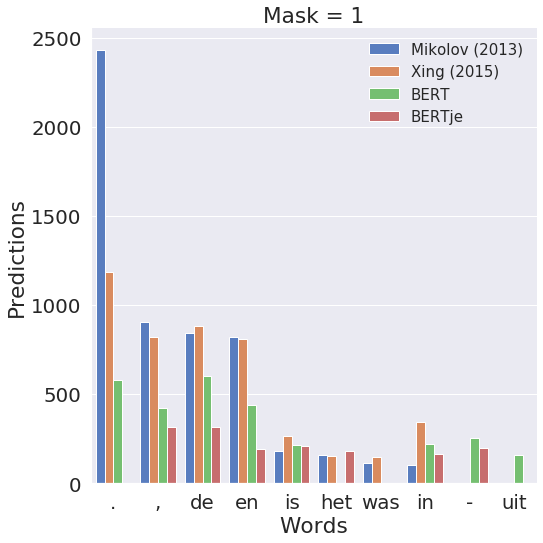

In [1]:
#Displaying Results

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

methods = ['mikolov', 'xing', 'english', 'native']
#some words aren't in the file generated from generate_dict.py and need to be translated
bidict = {'from':'van', 'it':'het', 'one':'een', 'to':'naar', 'again':'opnieuw'}
labels = {'mikolov':'Mikolov (2013)', 'xing':'Xing (2015)', 'english':'BERT', 'native':'BERTje'}
df = pd.DataFrame(data={'Words':[], 'Predictions':[], 'Method':[], 'Mask':[]})
sns.set(font_scale=1.8)

for method in methods:
    word_dists = torch.load('data/word_dist_'+method+'.pt')
    if method=='native':
        word_dist = word_dists[0].most_common(8)
        keys = [word[0] for word in word_dist]
        values = [word[1] for word in word_dist]
        
        data = pd.DataFrame(data={'Words':keys, 'Predictions':values, 'Method':labels[method], 'Mask':'1'})
        df = pd.concat([df, data], ignore_index=True)
    else:
        word_dist = word_dists[0].most_common(8)
        keys = [bidict[word[0]] if word[0] in bidict else word[0] for word in word_dist]
        values = [word[1] for word in word_dist]

        data = pd.DataFrame(data={'Words':keys, 'Predictions':values, 'Method':labels[method], 'Mask':'1'})
        df = pd.concat([df, data], ignore_index=True)

indexNames = df[df['Words'] == '[UNK]'].index
df.drop(indexNames, inplace=True)

sns.catplot(x="Words", y="Predictions", hue="Method", col='Mask', data=df,
                height=8, kind="bar", legend=False, palette='muted')

plt.legend(frameon=False, loc='upper right', fontsize=15)

plt.show()


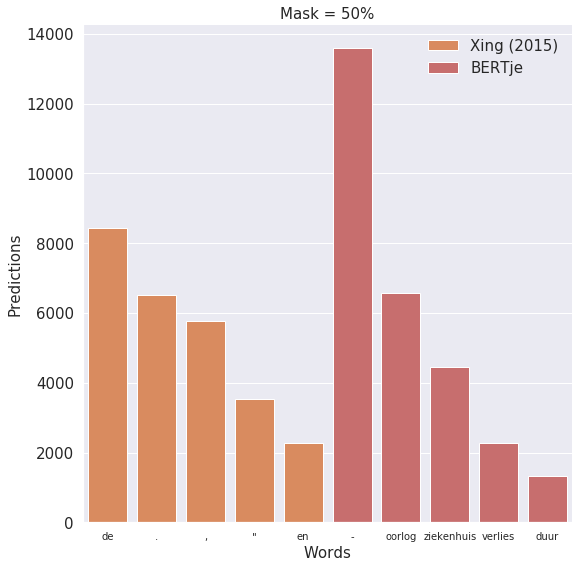

In [2]:
df = pd.DataFrame(data={'Words':[], 'Predictions':[], 'Method':[], 'Mask':[]})
sns.set(font_scale=1)
for method in methods:

    word_dists = torch.load('data/word_dist_'+method+'.pt')
    if method=='native':
        word_dist = word_dists[2].most_common(6)
        keys = [word[0] for word in word_dist]
        values = [word[1] for word in word_dist]
        
        data = pd.DataFrame(data={'Words':keys, 'Predictions':values, 'Method':labels[method], 'Mask':'50%'})
        df = pd.concat([df, data], ignore_index=True)
    elif method=='xing':
        word_dist = word_dists[2].most_common(5)
        keys = [bidict[word[0]] if word[0] in bidict else word[0] for word in word_dist]
        values = [word[1] for word in word_dist]

        data = pd.DataFrame(data={'Words':keys, 'Predictions':values, 'Method':labels[method], 'Mask':'50%'})
        df = pd.concat([df, data], ignore_index=True)

indexNames = df[df['Words'] == '[UNK]'].index
df.drop(indexNames, inplace=True)

sns.catplot(x="Words", y="Predictions", hue="Method", col='Mask', data=df,
                height=8, kind="bar", legend=False, palette=[sns.color_palette('muted')[i] for i in [1, 3]], dodge=False)

plt.legend(frameon=False, loc='upper right', fontsize=15)

plt.title('Mask = 50%', fontsize=15)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=15)

plt.show()

Here we use the saved accuracies from the POS-tagging task to get the means and standard deviations

In [3]:
tasks = ['1', '20%', '50%']
for method in methods:
    masking = torch.load('data/masking_score_'+method+'.pt')
    pos = torch.load('data/pos_task_'+method+'.pt')
    print(labels[method])
    print()
    print('masking:')
    for i, result in enumerate(masking):
        CE_loss = [loss[0] for loss in result]
        perplexity = [loss[1] for loss in result]
        std, mean = torch.std_mean(torch.tensor(CE_loss))
        std_pp, mean_pp = torch.std_mean(torch.tensor(perplexity))
        print(tasks[i]+' token masking')
        print('CE_loss: %.2f +/- %.2f' % (mean, std))
        print('Perplexity: %.2f +/- %.2f' % (mean_pp, std_pp))
        print()

    print('pos-tagging task:')
    pos_task = ['POS-accuracy', 'Control-accuracy']
    for i, result in enumerate(pos):
        std_pos, mean_pos = torch.std_mean(torch.tensor(result))
        print(pos_task[i]+': %.2f +/- %.2f' % (mean_pos, std_pos))
    print()

Mikolov (2013)

masking:
1 token masking
CE_loss: 7.81 +/- 0.02
Perplexity: 61165.09 +/- 5663.68

20% token masking
CE_loss: 7.28 +/- 0.01
Perplexity: 10988.74 +/- 456.64

50% token masking
CE_loss: 7.04 +/- 0.01
Perplexity: 6356.09 +/- 180.23

pos-tagging task:
POS-accuracy: 0.95 +/- 0.01
Control-accuracy: 0.87 +/- 0.00

Xing (2015)

masking:
1 token masking
CE_loss: 6.93 +/- 0.02
Perplexity: 24285.17 +/- 357.15

20% token masking
CE_loss: 6.85 +/- 0.02
Perplexity: 8325.31 +/- 116.08

50% token masking
CE_loss: 6.82 +/- 0.01
Perplexity: 7466.17 +/- 3477.84

pos-tagging task:
POS-accuracy: 0.95 +/- 0.00
Control-accuracy: 0.87 +/- 0.00

BERT

masking:
1 token masking
CE_loss: 7.36 +/- 0.02
Perplexity: 25504.63 +/- 1183.48

20% token masking
CE_loss: 7.32 +/- 0.02
Perplexity: 9997.20 +/- 387.86

50% token masking
CE_loss: 7.09 +/- 0.02
Perplexity: 5655.05 +/- 177.35

pos-tagging task:
POS-accuracy: 0.95 +/- 0.01
Control-accuracy: 0.89 +/- 0.01

BERTje

masking:
1 token masking
CE_loss: 6